<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/6a_kmedias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamiento mediante K-medias
En esta libreta programaremos el algoritmo de agrupamiento K-medias, el cual aplicaremos a distintos conjuntos de datos. 

In [0]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans

## Funciones para asignación y recálculo de centroides
El algoritmo de K-medias es un algoritmo iterativo que está compuesto de 2 pasos fundamentales:
1. Asignación de cada punto a su centroide más cercano. 


In [0]:
def asigna_puntos_a_centroides(puntos, centroides):
  grupos = np.zeros(puntos.shape[0])
  distancias = np.zeros(puntos.shape[0])
  for i,p in enumerate(puntos):
    grupos[i] = np.argmin(np.linalg.norm(centroides - p, axis = 1))
    distancias[i] = np.min(np.linalg.norm(centroides - p, axis = 1))
  return grupos, distancias

2. Recálculo de nuevos centroides a partir de las asignaciones. 

In [0]:
def recalcula_centroides(puntos, grupos, k):
  nuevos_centroides = np.zeros((k, puntos.shape[1]))
  for i in range(k):
    nuevos_centroides[i,:] = puntos[np.where(grupos == i), :].mean(axis = 1)

  return nuevos_centroides

En K-medias se inicializan los centroides y posteriormente itera entre estos 2 pasos hasta que se cumple un criterio de convergencia (por ej. un número de iteraciones). De esta forma se van actualizando tanto los centroides como las asignaciones hasta converger a un agrupamiento. En particular, este algoritmo busca minimizar la siguiente función de error

$$
E[\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K] = \sum_{i=1}^N \sum_{k=1}^K r_{ik} \Vert \mathbf{x}_i - \boldsymbol{\mu}_k \Vert²
$$

donde $r_{ik} = 1$ si $\boldsymbol{\mu}_k$ es el centroide más cercano a $\mathbf{x}_i$ y $r_{ik} = 0$ en caso contrario

In [0]:
def kmeans(puntos, n_grupos=3, n_iter=9, grafica=True):
  permutacion = np.random.permutation(puntos.shape[0])
  viejos_centroides = puntos[permutacion[:n_grupos], :]

  if grafica:  
    plt.figure(figsize=(14,14))

  es = np.zeros(n_iter + 1)
  for it in range(n_iter):
    grupos, dists = asigna_puntos_a_centroides(puntos, viejos_centroides)
    if grafica:
      plt.subplot(3, 3, it + 1)
      grafica_grupos(puntos, grupos, title='Iteración ' + str(it), centroides=viejos_centroides)
    es[it] = np.square(dists).mean()

    nuevos_centroides = recalcula_centroides(puntos, grupos, n_grupos)
    viejos_centroides = nuevos_centroides

  grupos, dists = asigna_puntos_a_centroides(puntos, nuevos_centroides)
  es[-1] = np.square(dists).mean()
  
  return nuevos_centroides, grupos, es

## Caso de estudio 1: conjunto de flores iris
Como caso de estudio vamos a agrupar las flores iris por su largo y ancho del pétalo. Para este ejemplo podemos graficar los puntos y sus correspondientes asignaciones.

In [0]:
def grafica_grupos(puntos, grupos, title, centroides=np.array([])):
  plt.plot(puntos[np.where(grupos == 0), 0],
           puntos[np.where(grupos == 0), 1],
           'r.', markersize=10)
  plt.plot(puntos[np.where(grupos == 1), 0],
           puntos[np.where(grupos == 1), 1],
           'g.', markersize=10)
  plt.plot(puntos[np.where(grupos == 2), 0],
           puntos[np.where(grupos == 2), 1],
           'b.', markersize=10)
  
  if centroides.size!=0:
    plt.plot(centroides[0, 0], centroides[0, 1], 'ro', markersize=10)
    plt.plot(centroides[1, 0], centroides[1, 1], 'go', markersize=10)
    plt.plot(centroides[2, 0], centroides[2, 1], 'bo', markersize=10)
  plt.title(title)
  plt.xlabel('Ancho del pétalo')
  plt.ylabel('Largo del pétalo')

Primero cargamos los datos usando el moódulo `datasets` de scikit-learn y los graficamos.

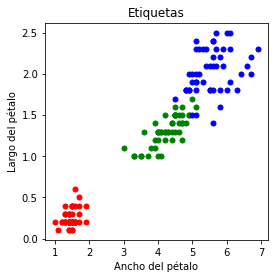

In [6]:
iris = datasets.load_iris()
datos_iris = iris['data']
datos_iris = datos_iris[:, 2:]

plt.figure(1, figsize=(4,4))
grafica_grupos(datos_iris, iris['target'], title='Etiquetas')
plt.show()

Corremos el algoritmo K-medias en los datos por 6 iteraciones con $K = 3$.

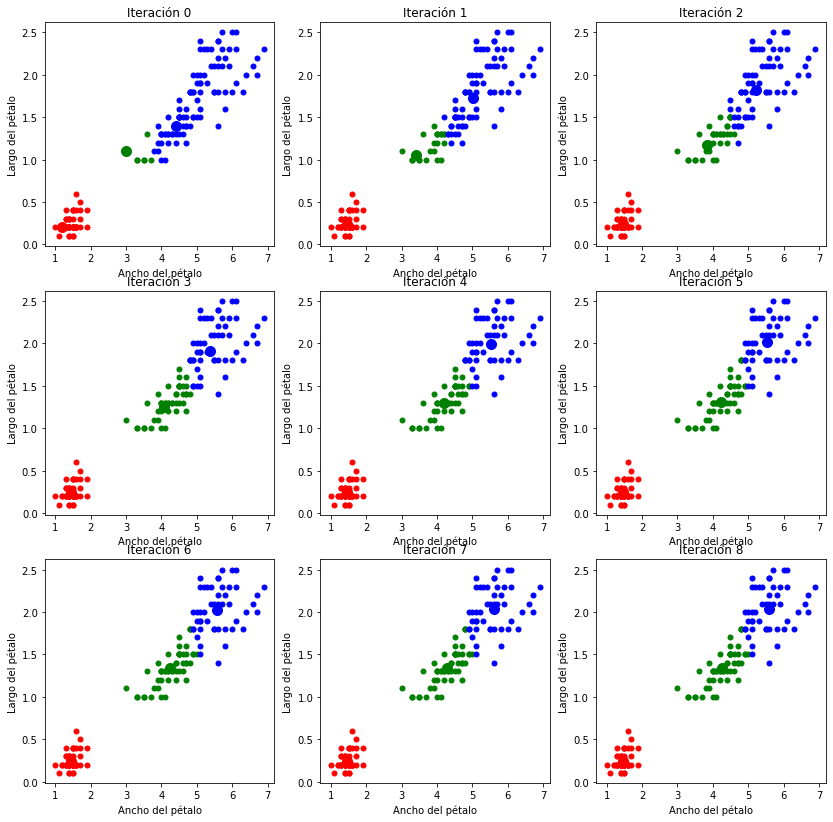

In [7]:
c_km_iris, g_km_iris, e_km_iris = kmeans(datos_iris, n_grupos = 3)

Graficamos el resultado del agrupamiento y lo comparamos con las etiquetas del conjunto de datos iris.

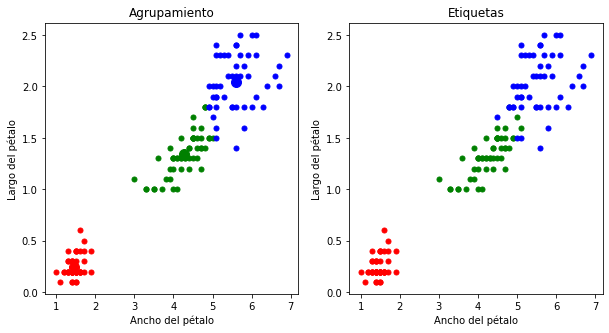

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
grafica_grupos(datos_iris, g_km_iris, 'Agrupamiento', centroides=c_km_iris)
plt.subplot(1,2,2)
grafica_grupos(datos_iris, iris['target'], title='Etiquetas')
plt.show()

Finalmente graficamos el valor de $E$ en cada iteración del algoritmo

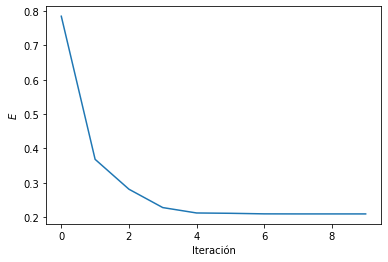

In [9]:
plt.plot(e_km_iris)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()

## Caso de estudio 2: Agrupamiento de imágenes de dígitos
Nuestro segundo caso de estudio es el agrupamiento de dígitos escritos a mano. Para ello, usaremos el conjunto de datos Digits de scikit-learn, el cual tiene imágenes de $8 \times 8$ pixeles en escala de grises.

Vamos a cargar y visualizar algunas de las imágenes:

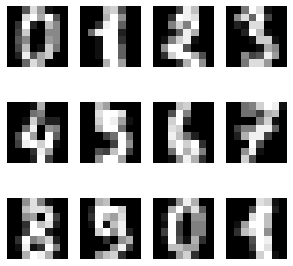

In [10]:
digits = datasets.load_digits()

plt.figure(figsize=(5,5))
for i in range(12):
  plt.subplot(3,4, i + 1)
  plt.imshow(digits.images[i], cmap='gray')
  plt.axis('off')
plt.show()

Para poder aplicar el algoritmo de K-medias debemos vectorizar las imágenes


In [0]:
X_digits = digits.images.reshape(digits.images.shape[0], 64)

Corremos el algoritmo sobre estos vectores por 10 iteraciones con $K=10$

In [0]:
c_km_digits, g_km_digits, e_km_digits = kmeans(X_digits, n_grupos=10, n_iter=10, grafica=False)

Visualizamos los centroides generados por el algoritmo

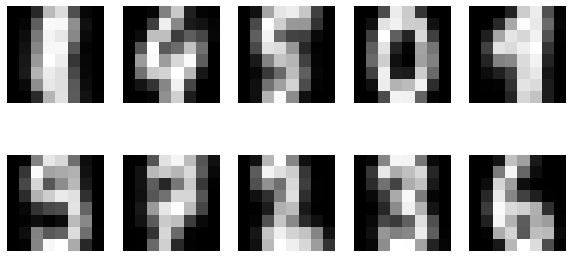

In [13]:
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(c_km_digits[i].reshape(8,8), cmap='gray')
  plt.axis('off')
plt.show()

Visualizamos algunas imágenes asignadas a cada uno de los 10 grupos

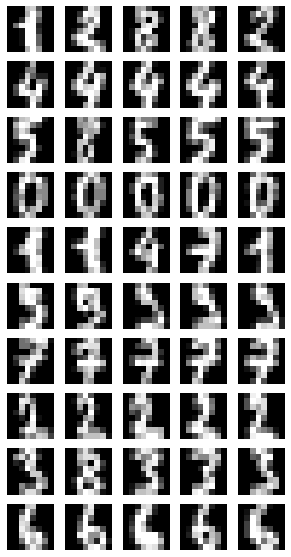

In [14]:
plt.figure(figsize=(5,10))
for i in range(10):
  m = g_km_digits == i
  for j in range(5):
    plt.subplot(10, 5, i * 5 + j + 1)
    plt.imshow(X_digits[m][j].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()

Y graficamos el valor de $E$ por iteración.

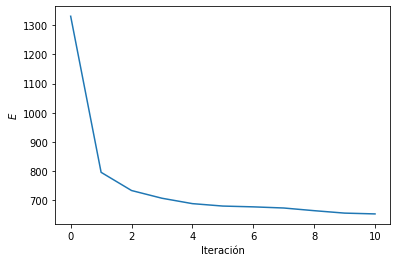

In [15]:
plt.plot(e_km_digits)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()

## K-medias por mini lotes (MiniBatchKMeans)
Es una versión del algoritmo de K-medias que usa lotes pequeños de datos para actualizar los centroides y las asignaciones.

In [0]:
def kmeans_minilotes(puntos, n_grupos=3, t_lote=10, n_iter=10):
  n_puntos = puntos.shape[0]
  permutacion = np.random.permutation(n_puntos)
  centroides = puntos[permutacion[:n_grupos], :]
  n_lotes = int(n_puntos / t_lote)

  cuentas = np.zeros(n_grupos)
  es = np.zeros(n_iter + 1)
  for it in range(n_iter):
    err = np.zeros(n_lotes)
    for l in range(n_lotes):
      permutacion = np.random.permutation(n_puntos)
      muestras = puntos[permutacion[:t_lote]]
      grupos, dists = asigna_puntos_a_centroides(muestras, centroides)
      err[l] = np.square(dists).sum()
      for j,x in enumerate(muestras):
        k = int(grupos[j])
        cuentas[k] += 1
        eta = 1.0 / cuentas[k]
        centroides[k] = (1.0 - eta) * centroides[k] + eta * x

    es[it] = err.sum() / (n_lotes * t_lote)

  grupos, dists = asigna_puntos_a_centroides(puntos, centroides)
  es[-1] = np.square(dists).mean()

  return centroides, grupos, es

Corremos el algoritmo de K-medias por mini lotes por 10 iteraciones para 3 grupos.

In [0]:
c_kml_iris, g_kml_iris, e_kml_iris = kmeans_minilotes(datos_iris, n_grupos=3, n_iter=10)

Visualizamos los grupos

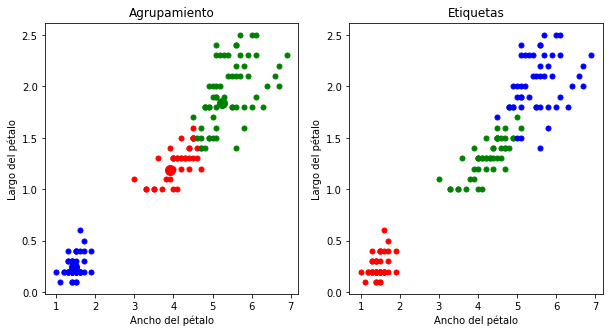

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
grafica_grupos(datos_iris, g_kml_iris, 'Agrupamiento', centroides=c_kml_iris)
plt.subplot(1,2,2)
grafica_grupos(datos_iris, iris['target'], title='Etiquetas')
plt.show()

Graficamos el error en cada iteración

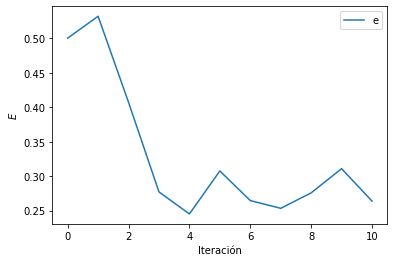

In [19]:
plt.plot(e_kml_iris, label='e')
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.legend()
plt.show()

Probamos también K-medias por minilotes en el conjunto de datos de dígitos

In [0]:
c_kml_digits, g_kml_digits, e_kml_digits = kmeans_minilotes(X_digits, n_grupos=10, n_iter=10)

Visualizamos los centroides encontrados por el algoritmo

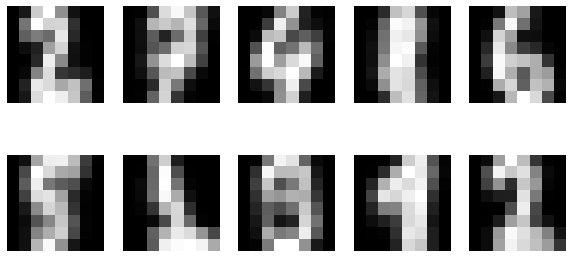

In [21]:
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(c_kml_digits[i].reshape(8,8), cmap='gray')
  plt.axis('off')
plt.show()

Examinamos algunos ejemplos asignados a cada grupo

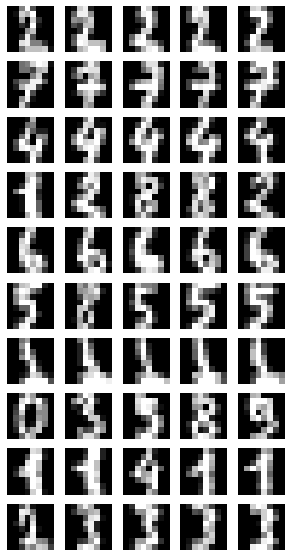

In [22]:
plt.figure(figsize=(5,10))
for i in range(10):
  m = g_kml_digits == i
  for j in range(5):
    plt.subplot(10, 5, i * 5 + j + 1)
    plt.imshow(X_digits[m][j].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()

Graficamos el error en cada iteración

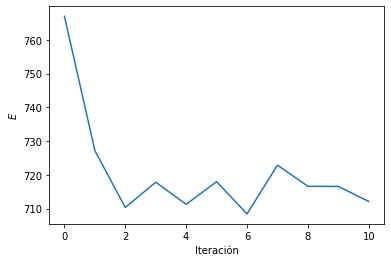

In [23]:
plt.plot(e_kml_digits)
plt.xlabel('Iteración')
plt.ylabel('$E$')
plt.show()